# Sampling strategy using a Moving Vessel Profiler (MVP) along transects in a rotated radiator grid
## Find spatial coordinates and time of the extremes of each transect and of each profile

This code provides the (lon, lat, time) coordinates of the extremes of each transect (information needed for navigation), as well as the (lon, lat, depth, time) coordinates of each MVP profile on a rotated sampling grid (information needed to do OSSEs). It needs as inputs: 
* Northwestern position (position where the sampling starts)
* Sampling strategy parameters: length of transects, separation between transects, number of transects and angle of the rotated grid
* MVP parameters: time resolution (cycle time) and maximum depth
* Ship velocity in knots
* Minimum profile depth and vertical resolution
* Initial date and time of the sampling

Note that this strategy consists of a vessel moving from west to east sampling one transect, then moving down to the next transect, which will be sampled from east to west, and so on. 

Also note that transects are not zonal, but they are forming an angle with the x-axis. The angle is positive counter-clockwise.

**Assumptions for the OSSEs**: 

* We assume that we release the MVP at the beggining of transect 1, we recover the MVP at the end of transect 1, navigate from transect 1 to transect 2 at the same velocity, release the MVP at the beggining of transect 2, recover MVP at the end of transect 2, and so on.

* We assume a vertical profile for each cycle of the MVP.


*Code written by Bàrbara Barceló-Llull (IMEDEA, Spain) and Elisabet Verger-Miralles (UIB-IMEDEA, Spain) in the framework of the FaSt-SWOT project to plan the FaSt-SWOT experiments. This code is based on the codes developed during the H2020 EuroSea project ([Barceló-Llull, 2023](https://doi.org/10.5281/zenodo.7543697)).  11 April 2023.*

*The FaSt-SWOT project is funded by the Spanish Research Agency and the European Regional Development Fund (AEI/FEDER, UE) under Grant Agreement (PID2021-122417NB-I00)).*

*The EuroSea project is funded by the European Union’s Horizon 2020 research and innovation programme under grant agreement No 862626.*

***

## Inputs to define the sampling strategy

* NW coordinate of the sampling domain (position where the sampling starts)

In [1]:
lon_ini = 3.435
lat_ini = 39.2  

* Parameters to define sampling strategy:

In [2]:
len_trans       = 50   # [km] length of each zonal transect
sep_trans       = 10   # [km] separation between zonal transects
num_trans       = 4    # total number of transects

* Angle of the sampling grid with the x-axis (zonal axis) (positive contour-clockwise): 

In [3]:
angle = 360-12   # [degrees] 

* Ship speed in [knots]

In [4]:
ship_speed_kt   = 4  # [knots]

* MVP parameters: (check the parameters of your instrument, our instrument is MVP30-350 from AML Oceanographic)

In [5]:
dep_uctd_max    = 200  #  [m]  maximum depth of each profile  
dtime_min       = 7    #  [minutes] time resolution = cycle time

* Minimum profile depth and vertical resolution

In [6]:
dep_uctd_min = 5      # [m] upper depth layer
dep_uctd_res = 0.5    # [m] vertical resolution of the data

* Start time of the sampling (year, month, day, hour, minute, second)


In [7]:
yy_exp, mm_exp, dd_exp, hh_exp, min_exp, sec_exp = 2023, 4, 24, 6, 0, 0

## Inputs for figures 

* Limits of the domain for the bigger maps:

In [8]:
lonmin, lonmax, latmin, latmax = 1, 5, 37.5, 40.5 # Balearic Sea

* Do you want to plot the SWOT swaths?

In [9]:
plot_swot = True # True or False

If True, provide the SWOT swaths directory and file:

In [10]:
dir_swaths = '/Users/bbarcelo/HOME_SCIENCE/Data/2023_FAST-SWOT/planning/swath_swot/'
    
file_swaths1 = 'MED_fastPhase_1km_swotFAST_grid_p009.nc'
file_swaths2 = 'MED_fastPhase_1km_swotFAST_grid_p022.nc'

* Do you want to plot the bathymetry?

In [11]:
plot_topo = True # True or False

If True, provide the bathymetry directory and file:

In [12]:
dir_topo    = '/Users/bbarcelo/HOME_SCIENCE/Data/2023_FAST-SWOT/planning/bathymetry/'

file_topo   = 'usgsCeSrtm30v6_8303_496d_dd25.nc'

* Do you want to save figures?

In [13]:
save_fig = True # True of False

If True, provide the directory to save figures:

In [14]:
dir_fig  = '/Users/bbarcelo/HOME_SCIENCE/Figures/2023_FAST-SWOT/planning/OSSEs/'

## Inputs for OSSEs 

* Do you want to save (lon, lat, depth, time) of each MVP profile?

In [15]:
save_coord = True # True or False

If True, provide the directory and file name:

In [16]:
dir_dic   = '/Users/bbarcelo/HOME_SCIENCE/Data/2023_FAST-SWOT/planning/OSSEs/'
file_name = 'MVP_profiles_coordinates' 

### >>> End of inputs <<<
***

## Libraries 

In [17]:
import numpy                 as np
import matplotlib.pyplot     as plt
import matplotlib.gridspec   as gridspec
import cartopy.crs           as ccrs
import cartopy.feature       as cfeature
from matplotlib              import dates as mdates
from datetime                import datetime, timedelta

## Open files

Open files with SWOT swaths:

In [18]:
if plot_swot == True:
    
    import netCDF4               as netcdf
    
    nc    = netcdf.Dataset(dir_swaths + file_swaths1, 'r')
    latsw1  = nc.variables['lat'][:]   
    lonsw1  = nc.variables['lon'][:]  
    x_ac1   = nc.variables['x_ac'][:]  # "Across track distance from nadir"
    
    lonnd1  = nc.variables['lon_nadir'][:] 
    latnd1  = nc.variables['lat_nadir'][:] 
    nc.close()     

    nc    = netcdf.Dataset(dir_swaths + file_swaths2, 'r')
    latsw2  = nc.variables['lat'][:]   
    lonsw2  = nc.variables['lon'][:]  
    x_ac2   = nc.variables['x_ac'][:]  # "Across track distance from nadir"

    lonnd2  = nc.variables['lon_nadir'][:] 
    latnd2  = nc.variables['lat_nadir'][:]     
    
    nc.close()  

Open file with bathymetry:

In [19]:
if plot_topo == True:
    
    import netCDF4               as netcdf
    
    nc        = netcdf.Dataset(dir_topo + file_topo, 'r')
    lat_topo  = nc.variables['latitude'][:] 
    lon_topo  = nc.variables['longitude'][:] 
    topo      = nc.variables['topo'][:] # [m]  
    nc.close()

    # Limit region

    ilont_dom = np.where(np.logical_and(lon_topo>=lonmin-1, lon_topo<=lonmax+1))
    jlatt_dom = np.where(np.logical_and(lat_topo>=latmin-1, lat_topo<=latmax+1))
    
    lon_topo_dom = lon_topo[ilont_dom]
    lat_topo_dom = lat_topo[jlatt_dom][::-1] # increasing!!
    topo_dom     = topo[jlatt_dom,:].squeeze()[:, ilont_dom].squeeze()[::-1, :] #lat axis in increasing order
   
    lon_topo2d, lat_topo2d = np.meshgrid(lon_topo_dom, lat_topo_dom)

## Functions

In [20]:
def length_lon_lat_degs(lat_mean_deg):
      
  ''' 
  Function to infer the length of a degree of longitude
  and the length of a degree of latitude
  at a specific latitude position. 
  Assuming that the Earth is an ellipsoid.
  
  input:  latitude in DEGREES!!!
  output: length_deg_lon, length_deg_lat in meters
  
  from:
      https://en.wikipedia.org/wiki/Longitude#Length_of_a_degree_of_longitude
      https://en.wikipedia.org/wiki/Latitude#Length_of_a_degree_of_latitude
  '''  
  
  ''' Earth parameters '''
  lat_mean_rad = lat_mean_deg*(np.pi/180)  #in radians
  
  a = 6378137.0                # m (equatorial radius)
  b = 6356752.3142             # m  (polar radius)
  
  ecc_2 = (a**2 - b**2) / a**2 # eccentricity squared


  ''' The length of a degree of longitude is... '''
  
  divident_lon = (a*np.pi/180) * np.cos(lat_mean_rad)
  divisor_lon  = np.sqrt(1 - (ecc_2*np.sin(lat_mean_rad)*np.sin(lat_mean_rad)))
  
  length_deg_lon = divident_lon / divisor_lon 
  
  
  ''' The length of a degree of latitude is... '''
  
  divident_lat = (a*np.pi/180) * (1 - ecc_2)
  divisor_lat  = (1 - (ecc_2 * np.sin(lat_mean_rad) * np.sin(lat_mean_rad)))**(3/2)
  
  length_deg_lat = divident_lat / divisor_lat
  
  
  return length_deg_lon, length_deg_lat  

## Start date in datetime format

In [21]:
#[python format in num. of days]
t_samp_ini    = mdates.date2num(datetime(yy_exp, mm_exp, dd_exp, hh_exp, min_exp, sec_exp)) 

print('The experiment starts on [UTC]...', mdates.num2date(t_samp_ini))

The experiment starts on [UTC]... 2023-04-24 06:00:00+00:00


*** 
## Which is the horizontal resolution of the MVP profiles?

Considering the provided parameters, the horizontal resolution of the MVP profiles (distance between cycles) is :

In [22]:
kt2ms          = 0.514444 # 1 knot is 0.514444 m/s
ship_speed_ms  = ship_speed_kt * kt2ms #in m/s
print('Ship speed in knots...', ship_speed_kt)
print('Ship speed in m/s...', ship_speed_ms)


# horizontal resolution of the MVP profiles  
dtime_s         = dtime_min * 60 #time resolution in seconds
hres_uctd_km    = (dtime_s * ship_speed_ms)/1000 #  [km] 
print('')
print('The horizontal resolution of the MVP profiles is [km]...', hres_uctd_km)


Ship speed in knots... 4
Ship speed in m/s... 2.057776

The horizontal resolution of the MVP profiles is [km]... 0.86426592


***
## Which are the western and eastern coordinates of each transect?

Information needed for navigation.

### a) Find the western (lon, lat) coordinates of each transect

(lon_ini, lat_ini) are the western coordinates of the northern transect, from this point we compute the western coordinates of each transect. To do this, we use trigonometric functions.

We need to find from (lon_ini, lat_ini) the western position of the transects just below. The angle in this case is formed between the line joining these points and the y-axis. Because of this, in this case: 

$\cos\theta=\frac{dyy}{dist};dyy=dist\cdot\cos\theta$

$\sin\theta=\frac{dxx}{dist};dxx=dist\cdot\sin\theta$,

where $dist$ is the distance between transects ($dist$ = sep_trans [km], $dxx$ = dlon2_km, $dyy$ = dlat2_km).

Then change dxx and dyy from km to degrees of longitude and latitude, respectively.

In [23]:
# Length of a degree of longitude and latitude:
length_deg_lon, length_deg_lat = length_lon_lat_degs(lat_ini)

# Find distance along zonal and meridional axes [in km]
dlat2_km = sep_trans*np.cos(np.deg2rad(angle)) # in km
dlon2_km = sep_trans*np.sin(np.deg2rad(angle)) # in km

# Convert these distances to degrees of longitude and latitude, respectively.
dlon2_deg = dlon2_km / (length_deg_lon/1000)
dlat2_deg = dlat2_km / (length_deg_lat/1000)

# Calculate lon_west, lat_west    
lon_west = lon_ini + dlon2_deg*np.arange(num_trans) 
lat_west = lat_ini - dlat2_deg*np.arange(num_trans)


In [24]:
print('')
print('The western coordinates of each transect are...')
print('Lon:', lon_west)
print('Lat:', lat_west)
print('')


The western coordinates of each transect are...
Lon: [3.435      3.41093113 3.38686227 3.3627934 ]
Lat: [39.2        39.11189391 39.02378783 38.93568174]



### b) Find the eastern (lon, lat) coordinates of each transect 

$\cos\theta=\frac{dx}{dist}$; $dx=dist\cdot\cos\theta$

$\sin\theta=\frac{dy}{dist}$; $dy=dist\cdot\sin\theta$

Then change dx and dy from km to degrees of longitude and latitude, respectively.

Here $dist$ = len_trans.

In [25]:
# Find distance along zonal and meridional axes [in km]
dlon_tot_km = len_trans*np.cos(np.deg2rad(angle)) # in km
dlat_tot_km = len_trans*np.sin(np.deg2rad(angle)) # in km

# Convert these distances to degrees of longitude and latitude, respectively.
dlon_tot_deg = dlon_tot_km / (length_deg_lon/1000)
dlat_tot_deg = dlat_tot_km / (length_deg_lat/1000)

# Calculate lon_east, lat_east    
lon_east = lon_west + dlon_tot_deg
lat_east = lat_west + dlat_tot_deg

print('')
print('The eastern coordinates of each transect are...')
print('Lon:', lon_east)
print('Lat:', lat_east)
print('')


The eastern coordinates of each transect are...
Lon: [4.00117558 3.97710671 3.95303784 3.92896898]
Lat: [39.10636237 39.01825628 38.93015019 38.84204411]



### c) Find the time of the western and eastern transect extremes

Time needed to navigate one transect in [days]:

In [26]:
time_L_days = ((len_trans*1000)/ship_speed_ms) / (3600*24) #[s]
time_L_days

0.28122774476119056

Time needed to navigate from the end of one transect to the beggining of the next one in [days]:

In [27]:
time_S_days = ((sep_trans*1000)/ship_speed_ms) / (3600*24) #[s]
time_S_days

0.056245548952238114

Time of the western extremes in [days]:

In [28]:
time_west = np.ones(num_trans)*np.nan

for irow in np.arange(num_trans):
    # if transects are even: 0, 2, etc.
    if irow in np.arange(0, num_trans, 2):
    
        time_west[irow] = t_samp_ini + irow*(time_L_days + time_S_days)
    
    # if transects are odd: 1, 3, etc.
    elif irow in np.arange(1, num_trans, 2):   
    
        time_west[irow] = t_samp_ini + (irow+1)*time_L_days + irow*time_S_days

print('Time of the western extremes of each transect (year, month, day, hour, minute, second):')
mdates.num2date(time_west)

Time of the western extremes of each transect (year, month, day, hour, minute, second):


[datetime.datetime(2023, 4, 24, 6, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 24, 20, 50, 55, 769724, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 24, 22, 11, 55, 385154, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 25, 13, 2, 51, 154878, tzinfo=datetime.timezone.utc)]

Time of the eastern extremes in [days]:

In [29]:
time_east = np.ones(num_trans)*np.nan

for irow in np.arange(num_trans):
    # if transects are even: 0, 2, etc.
    if irow in np.arange(0, num_trans, 2):
    
        time_east[irow] = t_samp_ini + (irow+1)*time_L_days + irow*time_S_days
    
    # if transects are odd: 1, 3, etc.
    elif irow in np.arange(1, num_trans, 2):   
    
        time_east[irow] = t_samp_ini + irow*time_L_days + irow*time_S_days

print('Time of the eastern extremes of each transect (year, month, day, hour, minute, second):')
mdates.num2date(time_east)

Time of the eastern extremes of each transect (year, month, day, hour, minute, second):


[datetime.datetime(2023, 4, 24, 12, 44, 58, 77148, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 24, 14, 5, 57, 692577, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 25, 4, 56, 53, 462301, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 4, 25, 6, 17, 53, 77731, tzinfo=datetime.timezone.utc)]

### d) Make figure 

Figure with (lon, lat, time) of the extremes of each transect:

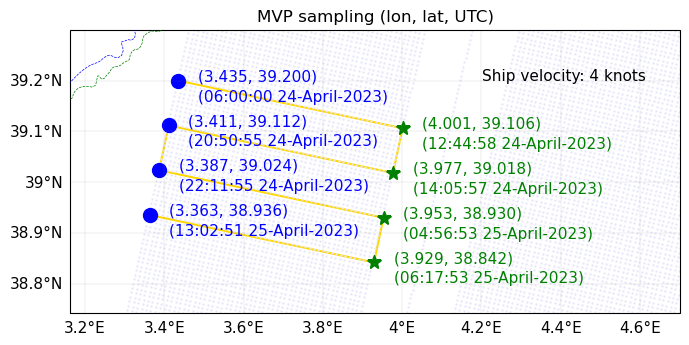

In [30]:
msize = 10  # marker size
fsize = 12 # text size

fig = plt.figure(figsize=(7,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.Mercator())

# plot (lon_west, lat_west) and (lon_east, lat_east)
ax.plot(lon_west, lat_west, 'ob', markersize=10, transform=ccrs.PlateCarree())    
ax.plot(lon_east, lat_east, '*g', markersize=10, transform=ccrs.PlateCarree())    

# text with coordinates and time 
for ii in np.arange(lon_west.shape[0]):
    
    # spatial coordinates western extremes
    ax.text(lon_west[ii]+0.05, lat_west[ii], 
            '(' + '{0:.3f}'.format(lon_west[ii]) + ', ' + '{0:.3f}'.format(lat_west[ii]) + ')', 
            color = 'b', fontsize = fsize-1,
            transform=ccrs.PlateCarree())

    # spatial coordinates eastern extremes
    ax.text(lon_east[ii]+0.05, lat_east[ii], 
            '(' + '{0:.3f}'.format(lon_east[ii]) + ', ' + '{0:.3f}'.format(lat_east[ii]) + ')', 
            color = 'g', fontsize = fsize-1,
            transform=ccrs.PlateCarree())
    
    # time western extremes
    ax.text(lon_west[ii]+0.05, lat_west[ii]-0.04, 
            '(' + mdates.num2date(time_west[ii]).strftime("%H:%M:%S %d-%B-%Y") + ')', 
            color = 'b', fontsize = fsize-1,
            transform=ccrs.PlateCarree())

    # time eastern extremes
    ax.text(lon_east[ii]+0.05, lat_east[ii]-0.04, 
            '(' + mdates.num2date(time_east[ii]).strftime("%H:%M:%S %d-%B-%Y") + ')', 
            color = 'g', fontsize = fsize-1,
            transform=ccrs.PlateCarree())   
    
# plot lines joining points    
for ii in np.arange(lon_west.shape[0]):
    ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], color='Gold', zorder=1,
                transform=ccrs.PlateCarree())
    
    if ii in np.arange(0, lon_west.shape[0], 2):
        ax.plot([lon_east[ii], lon_east[ii+1]], [lat_east[ii], lat_east[ii+1]], color='Gold', zorder=1,
                    transform=ccrs.PlateCarree())        
        
    if ii in np.arange(1, lon_west.shape[0]-2, 2):
        ax.plot([lon_west[ii], lon_west[ii+1]], [lat_west[ii], lat_west[ii+1]], color='Gold', zorder=1,
                    transform=ccrs.PlateCarree())           
# Add ship velocity
ax.text(lon_east.max()+0.2, lat_west.max(), 'Ship velocity: ' + str(ship_speed_kt) + ' knots', 
        fontsize = fsize-1, transform=ccrs.PlateCarree()) 


# bathymetry contours
if plot_topo == True:        
        
    cs1000 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-1000],#Blues_r, #cmo.haline, 
                       colors='g', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())
        
    cs500 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-500],#Blues_r, #cmo.haline, 
                       colors='b', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())


    # label the bathymetry contours
    plt.clabel(cs1000, fmt='%d', fontsize=fsize-3)
    plt.clabel(cs500, fmt='%d', fontsize=fsize-3)


# SWOT swaths
if plot_swot == True:
    ax.scatter(lonsw1.flatten(), latsw1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonsw2.flatten(), latsw2.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd1.flatten(), latnd1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd2.flatten(), latnd2.flatten(), c='lavender', s=msize/25, zorder=1, label='SWOT',
                    transform=ccrs.PlateCarree())
    
    
# title
ax.set_title('MVP sampling (lon, lat, UTC)', fontsize =fsize)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.2, color='gray', alpha=0.5, linestyle='-')

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': fsize-1}#, 'color': 'gray'}
gl.ylabel_style = {'size': fsize-1}#, 'color': 'gray'}
  
# domain extent
dsm = 0.2
dbg = 0.7
ax.set_extent([lon_west.min()-dsm, lon_east.max()+dbg, 
               lat_east.min()-dsm/2, lat_west.max()+dsm/2], crs=ccrs.PlateCarree())

plt.tight_layout()

if save_fig == True:
    
    fig.savefig(dir_fig + 
                'MVP_sampling_strategy_extreme_coordinates_small_region.png', 
                dpi=200)  

Bigger map: 

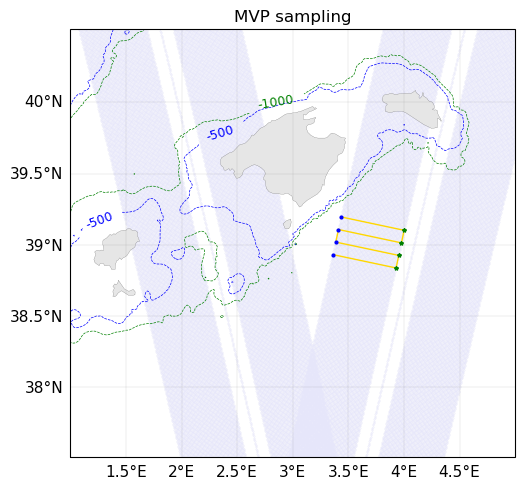

In [31]:
msize = 2  # marker size
fsize = 12 # text size

fig = plt.figure(figsize=(7,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.Mercator())

# plot (lon_west, lat_west) and (lon_east, lat_east)
ax.plot(lon_west, lat_west, 'ob', markersize=msize,
        zorder=4, transform=ccrs.PlateCarree())    
ax.plot(lon_east, lat_east, '*g', markersize=msize+1, 
        zorder=4, transform=ccrs.PlateCarree())    
    
# plot lines joining points    
for ii in np.arange(lon_west.shape[0]):
    ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], 
            color='Gold', zorder=3, linewidth=1,
                transform=ccrs.PlateCarree())
    
    if ii in np.arange(0, lon_west.shape[0], 2):
        ax.plot([lon_east[ii], lon_east[ii+1]], [lat_east[ii], lat_east[ii+1]], 
                color='Gold', zorder=3, linewidth=1,
                    transform=ccrs.PlateCarree())        
        
    if ii in np.arange(1, lon_west.shape[0]-2, 2):
        ax.plot([lon_west[ii], lon_west[ii+1]], [lat_west[ii], lat_west[ii+1]], 
                color='Gold', zorder=3, linewidth=1,
                    transform=ccrs.PlateCarree())           


# bathymetry contours
if plot_topo == True:        
        
    cs1000 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-1000],#Blues_r, #cmo.haline, 
                       colors='g', linewidths = 0.5, zorder=2, 
                    transform=ccrs.PlateCarree())
        
    cs500 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-500],#Blues_r, #cmo.haline, 
                       colors='b', linewidths = 0.5, zorder=2, 
                    transform=ccrs.PlateCarree())


    # label the bathymetry contours
    plt.clabel(cs1000, fmt='%d', fontsize=fsize-3)
    plt.clabel(cs500, fmt='%d', fontsize=fsize-3)


# SWOT swaths
if plot_swot == True:
    ax.scatter(lonsw1.flatten(), latsw1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonsw2.flatten(), latsw2.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd1.flatten(), latnd1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd2.flatten(), latnd2.flatten(), c='lavender', s=msize/25, zorder=1, 
                   label='SWOT', transform=ccrs.PlateCarree())
    
    
# title
ax.set_title('MVP sampling', fontsize =fsize)

# domain extent
ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

# Map decor 
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                          edgecolor='k',linewidth=0.1,
                                          facecolor='0.9' ) #cfeature.COLORS['land'])
ax.add_feature(land_10m)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.2, color='gray', alpha=0.5, linestyle='-')

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': fsize-1}#, 'color': 'gray'}
gl.ylabel_style = {'size': fsize-1}#, 'color': 'gray'}

plt.tight_layout()

if save_fig == True:
    
    fig.savefig(dir_fig + 
                'MVP_sampling_strategy_extreme_coordinates_big_region.png', 
                dpi=400)  

***
## Which are the spatial coordinates and time of each MVP profile?

Information needed to do OSSEs

### If the distance between profiles along each transect is hres_uctd_km, what's the distance along de zonal and meridional axes?

$\cos\theta=\frac{dx}{dist}$; $dx=dist\cdot\cos\theta$

$\sin\theta=\frac{dy}{dist}$; $dy=dist\cdot\sin\theta$

where $dist$ = hres_uctd_km.

Then change dx and dy from km to degrees of longitude and latitude, respectively.

In [32]:
# Length of a degree of longitude and latitude:
#length_deg_lon, length_deg_lat = length_lon_lat_degs(lat_ini)

# Find distance along zonal and meridional axes [in km]
dlon_km = hres_uctd_km*np.cos(np.deg2rad(angle)) # in km
dlat_km = hres_uctd_km*np.sin(np.deg2rad(angle)) # in km

# Convert these distances to degrees of longitude and latitude, respectively.
dlon_deg = dlon_km / (length_deg_lon/1000)
dlat_deg = dlat_km / (length_deg_lat/1000)

# redefine 
dlon_ctd = np.copy(dlon_deg)
dlat_ctd = np.copy(dlat_deg)

### Some clarifications about indices

The indices of the MVP profiles will be:

In [33]:
num_profs_intran   = int(len_trans / hres_uctd_km)
num_profs_total    = num_profs_intran * num_trans
inds               = np.arange(num_profs_total)

print('Indices... ', inds)

Indices...  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]


However, note that if transects are even, the indices will increase from west to east. If transects are odds, indices will increase from east to west. We need to remember this when assigning (lon, lat) to each cast.

### Find (lon, lat, depth, time) of each MVP profile along each transect

Temporal resolution of the MVP profiles in [days]:

In [34]:
dtime_days = dtime_min / (60*24) 
print('temporal resolution [min]...', dtime_min)
print('temporal resolution [days]...', dtime_days)

temporal resolution [min]... 7
temporal resolution [days]... 0.004861111111111111


Find (lon, lat, time) of each profile:

In [35]:
lon_MVP_profiles  = np.ones(num_profs_total) * np.nan
lat_MVP_profiles  = np.ones(num_profs_total) * np.nan
time_MVP_profiles = np.ones(num_profs_total) * np.nan 

 
for irow in np.arange(num_trans):
    
    print(' ')
    #print('Transect...', irow)
    #print(' ')
    
    # indices of the profiles along each trancect
    
    row_ind_min = irow*num_profs_intran
    row_ind_max = (irow+1)*num_profs_intran - 1
    
    #print('min index...', row_ind_min)
    #print('max index...', row_ind_max)

    
    # Compute and assign coordinates:
    
    # if transects are even: 0, 2, etc.
    if irow in np.arange(0, num_trans, 2):

        lon_tran  = lon_west[irow]  + dlon_ctd*np.arange(num_profs_intran)
        lat_tran  = lat_west[irow]  + dlat_ctd*np.arange(num_profs_intran)
        time_tran = time_west[irow] + dtime_days*np.arange(num_profs_intran)
    
        lon_MVP_profiles[row_ind_min:row_ind_max+1] = lon_tran
        lat_MVP_profiles[row_ind_min:row_ind_max+1] = lat_tran
        time_MVP_profiles[row_ind_min:row_ind_max+1] = time_tran
 
    # if transects are odd: 1, 3, etc.
    elif irow in np.arange(1, num_trans, 2):

        lon_tran  = lon_east[irow]  - dlon_ctd*np.arange(num_profs_intran)
        lat_tran  = lat_east[irow]  - dlat_ctd*np.arange(num_profs_intran)        
        time_tran = time_east[irow] + dtime_days*np.arange(num_profs_intran)  
        
        lon_MVP_profiles[row_ind_min:row_ind_max+1]  = lon_tran
        lat_MVP_profiles[row_ind_min:row_ind_max+1]  = lat_tran
        time_MVP_profiles[row_ind_min:row_ind_max+1] = time_tran
        
#print('')
#print('The longitude of each profile is...', lon_MVP_profiles)
#print('')
#print('The latitude of each profile is...', lat_MVP_profiles)
#print('')
#print('The time of each profile is...', mdates.num2date(time_MVP_profiles))

Find depth axis for MVP profiles:

In [36]:
# define depth axis for uCTD profiles
dep_axis = np.arange(dep_uctd_min, dep_uctd_max+dep_uctd_res, dep_uctd_res)

Save (lon, lat, dep, time) of MVP profiles in a pickle file:

In [37]:
if save_coord == True:
    
    import pickle
    
    # Create dictionary
    dic_MVP_pfs  = {}

    # Save data in dictionary
    dic_MVP_pfs.update({'time_ctd': time_MVP_profiles, 
                        'lon_ctd' : lon_MVP_profiles,
                        'lat_ctd' : lat_MVP_profiles,
                        'dep_ctd' : dep_axis}) 

    # Save dictionary in a pickle file
    f_MVP = open(dir_dic + file_name + '.pkl','wb')
    pickle.dump(dic_MVP_pfs, f_MVP)
    f_MVP.close()         

### Make figure in a small domain

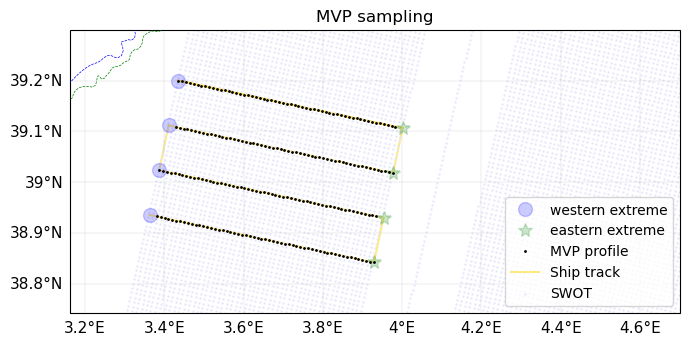

In [38]:
msize = 10  # marker size
fsize = 12 # text size

fig = plt.figure(figsize=(7,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.Mercator())

# plot (lon_west, lat_west) and (lon_east, lat_east)
ax.plot(lon_west, lat_west, 'ob', alpha = 0.2, 
        markersize=msize, label = 'western extreme', transform=ccrs.PlateCarree())    
ax.plot(lon_east, lat_east, '*g', alpha = 0.2, 
        markersize=msize, label = 'eastern extreme', transform=ccrs.PlateCarree())   
ax.plot(lon_MVP_profiles, lat_MVP_profiles, 'ok', 
        markersize=msize/10, label = 'MVP profile', transform=ccrs.PlateCarree())  

# plot lines joining points   
write_label = True
for ii in np.arange(lon_west.shape[0]):
    ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], 
            color='Gold', zorder=1, alpha = 0.5, 
                transform=ccrs.PlateCarree())
    
    #only show the label once in the legend
    if write_label == True: 
        ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], 
                color='Gold', zorder=1, alpha = 0.5, label = 'Ship track',
                    transform=ccrs.PlateCarree())    
        
        write_label = False
    
    if ii in np.arange(0, lon_west.shape[0], 2):
        ax.plot([lon_east[ii], lon_east[ii+1]], [lat_east[ii], lat_east[ii+1]], 
                color='Gold', zorder=1, alpha = 0.5, 
                    transform=ccrs.PlateCarree())        
        
    if ii in np.arange(1, lon_west.shape[0]-2, 2):
        ax.plot([lon_west[ii], lon_west[ii+1]], [lat_west[ii], lat_west[ii+1]], 
                color='Gold', zorder=1, alpha = 0.5, 
                    transform=ccrs.PlateCarree())  

# bathymetry contours
if plot_topo == True:        
        
    cs1000 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-1000],#Blues_r, #cmo.haline, 
                       colors='g', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())
        
    cs500 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-500],#Blues_r, #cmo.haline, 
                       colors='b', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())


    # label the bathymetry contours
    plt.clabel(cs1000, fmt='%d', fontsize=fsize-3)
    plt.clabel(cs500, fmt='%d', fontsize=fsize-3)


# SWOT swaths
if plot_swot == True:
    ax.scatter(lonsw1.flatten(), latsw1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonsw2.flatten(), latsw2.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd1.flatten(), latnd1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd2.flatten(), latnd2.flatten(), c='lavender', s=msize/25, zorder=1, label='SWOT',
                    transform=ccrs.PlateCarree())
    
plt.legend(loc='lower right')

# title
ax.set_title('MVP sampling', fontsize =fsize)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.2, color='gray', alpha=0.5, linestyle='-')

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': fsize-1}#, 'color': 'gray'}
gl.ylabel_style = {'size': fsize-1}#, 'color': 'gray'}
  
# domain extent
dsm = 0.2
dbg = 0.7
ax.set_extent([lon_west.min()-dsm, lon_east.max()+dbg, 
               lat_east.min()-dsm/2, lat_west.max()+dsm/2], crs=ccrs.PlateCarree())

plt.tight_layout()

if save_fig == True:
    
    fig.savefig(dir_fig + 
                'MVP_sampling_strategy_profiles_small_map_across_SWATH.png', 
                dpi=200)  

### Make figure in a bigger domain

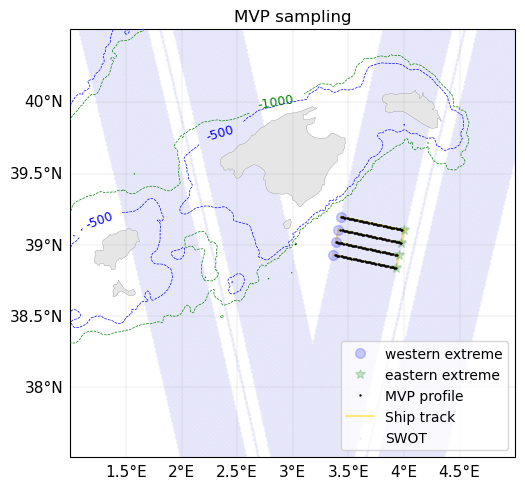

In [39]:
msize = 7  # marker size
fsize = 12 # text size

fig = plt.figure(figsize=(7,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.Mercator())

    
# plot (lon_west, lat_west) and (lon_east, lat_east)
ax.plot(lon_west, lat_west, 'ob', alpha = 0.2, 
        markersize=msize, label = 'western extreme', zorder = 3, 
        transform=ccrs.PlateCarree())    
ax.plot(lon_east, lat_east, '*g', alpha = 0.2, 
        markersize=msize, label = 'eastern extreme', zorder = 3,
        transform=ccrs.PlateCarree())   
# plot (lon, lat) of each profile
ax.plot(lon_MVP_profiles, lat_MVP_profiles, 'ok', 
        markersize=msize/10, label = 'MVP profile', zorder = 3,
        transform=ccrs.PlateCarree())  

# plot lines joining points   
write_label = True
for ii in np.arange(lon_west.shape[0]):
    ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], 
            color='Gold', zorder=2, alpha = 0.5, 
                transform=ccrs.PlateCarree())
    
    #only show the label once in the legend
    if write_label == True: 
        ax.plot([lon_west[ii], lon_east[ii]], [lat_west[ii], lat_east[ii]], 
                color='Gold', zorder=2, alpha = 0.5, label = 'Ship track',
                    transform=ccrs.PlateCarree())    
        
        write_label = False
    
    if ii in np.arange(0, lon_west.shape[0], 2):
        ax.plot([lon_east[ii], lon_east[ii+1]], [lat_east[ii], lat_east[ii+1]], 
                color='Gold', zorder=2, alpha = 0.5, 
                    transform=ccrs.PlateCarree())        
        
    if ii in np.arange(1, lon_west.shape[0]-2, 2):
        ax.plot([lon_west[ii], lon_west[ii+1]], [lat_west[ii], lat_west[ii+1]], 
                color='Gold', zorder=2, alpha = 0.5, 
                    transform=ccrs.PlateCarree())  
# bathymetry contours
if plot_topo == True:        
        
    cs1000 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-1000],#Blues_r, #cmo.haline, 
                       colors='g', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())
        
    cs500 = ax.contour(lon_topo2d, lat_topo2d, topo_dom, levels=[-500],#Blues_r, #cmo.haline, 
                       colors='b', linewidths = 0.5, zorder=1000, 
                    transform=ccrs.PlateCarree())


    # label the bathymetry contours
    plt.clabel(cs1000, fmt='%d', fontsize=fsize-3)
    plt.clabel(cs500, fmt='%d', fontsize=fsize-3)


# SWOT swaths
if plot_swot == True:
    ax.scatter(lonsw1.flatten(), latsw1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonsw2.flatten(), latsw2.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd1.flatten(), latnd1.flatten(), c='lavender', s=msize/25, zorder=1,
                    transform=ccrs.PlateCarree())
    ax.scatter(lonnd2.flatten(), latnd2.flatten(), c='lavender', s=msize/25, zorder=1, label='SWOT',
                    transform=ccrs.PlateCarree())
        
# legend
plt.legend(loc='lower right')

# title
ax.set_title('MVP sampling', fontsize =fsize)

# domain extent
ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

# Map decor 
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                          edgecolor='k',linewidth=0.1,
                                          facecolor='0.9' ) #cfeature.COLORS['land'])
ax.add_feature(land_10m)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.2, color='gray', alpha=0.5, linestyle='-')

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': fsize-1}#, 'color': 'gray'}
gl.ylabel_style = {'size': fsize-1}#, 'color': 'gray'}
  

plt.tight_layout()

if save_fig == True:
    
    fig.savefig(dir_fig + 
                'MVP_sampling_strategy_profiles_big_map_across_SWATH.png', 
                dpi=200)  